In [61]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak


In [62]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LeastSquaresLoss, BaseOracle
from experiments.methods import *

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [110]:
np.random.seed(0)


n = 1000
d = 20
noise = 0.1

dataset_name = f"synthetic {noise=}"

oracle = LeastSquaresLoss()

A = np.random.randn(n, d)
wOpt = np.random.randn(d)
b = A@wOpt + noise * np.random.randn(n)

train_data = A.copy()
train_target = b.copy()
test_data = train_data.copy()
test_target = train_target.copy()

dataset = train_data, train_target, test_data, test_target
batch_size = train_data.shape[0]

wOpt = np.linalg.inv(A.T@A) @ (A.T @ b)
L = np.max(np.linalg.eig(np.matmul(A.T,A))[0]) / n
fOpt = oracle.func(wOpt, A, b)
fOpt

0.004897462659626299

In [139]:
dataset_name = "housing_scale"
train_data, train_target, test_data, test_target = utils.get_libsvm(dataset_name, test_split=0.0)

batch_size = train_data.shape[0]

wOpt = scipy.sparse.linalg.inv(train_data.T.dot(train_data)).dot(train_data.T.dot(train_target))
L = scipy.sparse.linalg.svds(train_data)[1][0] ** 2

oracle = LeastSquaresLoss()
fOpt = oracle.func(wOpt, train_data, train_target)
print(f"{fOpt=}")

print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")

dataset = train_data, train_target, test_data, test_target

fOpt=12.135776624189537
1/L=0.014883053551563906
batch_size=506
train_data.shape=(506, 13), test_data.shape=(506, 13)


In [130]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, f_star=None, suptitle=None, 
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    # if f_star is None:
    #     f_star = np.min([x["loss"] for x in histories])
    # else:
    #     f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        # f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
        # f_suboptim[f_suboptim < threshold] = 0.0
        try:
            markevery = [x + np.random.randint(0, 1) for x in range(0, len(history["test/loss"]), len(history["test/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(history["test/loss"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].semilogy(history["test/grad_norm_sq"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)
        ax[2].plot(history["lr"], linestyle=ls, linewidth=lw, color=c)


    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
        
    ax[2].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show()    

In [131]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LeastSquaresLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss = loss_function.func(params, test_data, test_target)
        grad = loss_function.grad(params, test_data, test_target)
        
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/grad_norm_sq"].append(g_norm_sq)
        
        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss = loss_function.func(params, batch_data, batch_target)
            train_grad = loss_function.grad(params, batch_data, batch_target)

            
            optim.step(loss=train_loss, grad=train_grad)
            history["lr"].append(optim.lr)

    # Evaluation 
    loss = loss_function.func(params, test_data, test_target)
    grad = loss_function.grad(params, test_data, test_target)
    
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    return history

In [132]:
class SPS(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 f_star: float = 0.0,
                 eta_max: float = np.inf):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.f_star = f_star
        self.c = c
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
    def step(self, loss, grad):
        
        self.lr = (loss - self.f_star) / ( self.c * np.linalg.norm(grad)**2 + self.eps )
        self.lr = np.minimum(self.eta_max, self.lr)
        self.params -= self.lr * grad
            
        return loss, grad


class SPS_MA(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 eta_max: float = 0.0,
                 betas: tuple[float, float] = (0.9, 0.9)):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.c = c
        self.betas = betas
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
        self._step_t = 0
        
        self.sum_f = 0.0
        self.sum_g = np.zeros_like(self.params)
        
    def step(self, loss, grad):
        
        self._step_t += 1
        
        self.sum_f = self.betas[0] * self.sum_f + (1 - self.betas[0]) * loss
        self.sum_g = self.betas[1] * self.sum_g + (1 - self.betas[1]) * grad
        # sum_hat = self.sum_g / (1 - self.beta**self._step_t)

        self.lr = self.sum_f / ( self.c * np.linalg.norm(self.sum_g)**2 + self.eps )        
        self.params -= self.lr * grad
            
        return loss, grad

In [137]:
def twin_model(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params_x = np.zeros(train_data.shape[1])
    params_y = np.zeros(train_data.shape[1]) + 5.0

    # oracle 
    loss_function = LeastSquaresLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Evaluation 
    loss = loss_function.func(params_x, test_data, test_target)
    grad = loss_function.grad(params_x, test_data, test_target)
    
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            
            train_loss_x = loss_function.func(params_x, batch_data, batch_target)
            train_grad_x = loss_function.grad(params_x, batch_data, batch_target)
            
            train_loss_y = loss_function.func(params_y, batch_data, batch_target)
            train_grad_y = loss_function.grad(params_y, batch_data, batch_target)
                        
            # print(f"Before: {train_loss_x=}, {train_loss_y=}")
            
            if train_loss_x < train_loss_y:
                # print(f"{train_loss_x=} < {train_loss_y=}")
                params_x, params_y = params_y, params_x
                train_loss_x, train_loss_y = train_loss_y, train_loss_x
                train_grad_x, train_grad_y = train_grad_y, train_grad_x
                
            # print(f"After: {train_loss_x=}, {train_loss_y=} \n")

            # Optimization step
            lr =  (train_loss_x - train_loss_y) / (0.5 * np.linalg.norm(train_grad_x)**2 + 1e-8)
            params_x -= lr * train_grad_x
            
            history["lr"].append(lr)
        
        # Evaluation 
        loss_x = loss_function.func(params_x, test_data, test_target)
        loss_y = loss_function.func(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            grad_x = loss_function.grad(params_x, test_data, test_target)
            g_norm_sq = np.linalg.norm(grad_x)**2
            history["test/loss"].append(loss_x)
            history["test/grad_norm_sq"].append(g_norm_sq)
        else:
            grad_y = loss_function.grad(params_y, test_data, test_target)
            g_norm_sq = np.linalg.norm(grad_y)**2
            history["test/loss"].append(loss_y)
            history["test/grad_norm_sq"].append(g_norm_sq)

    
    return history

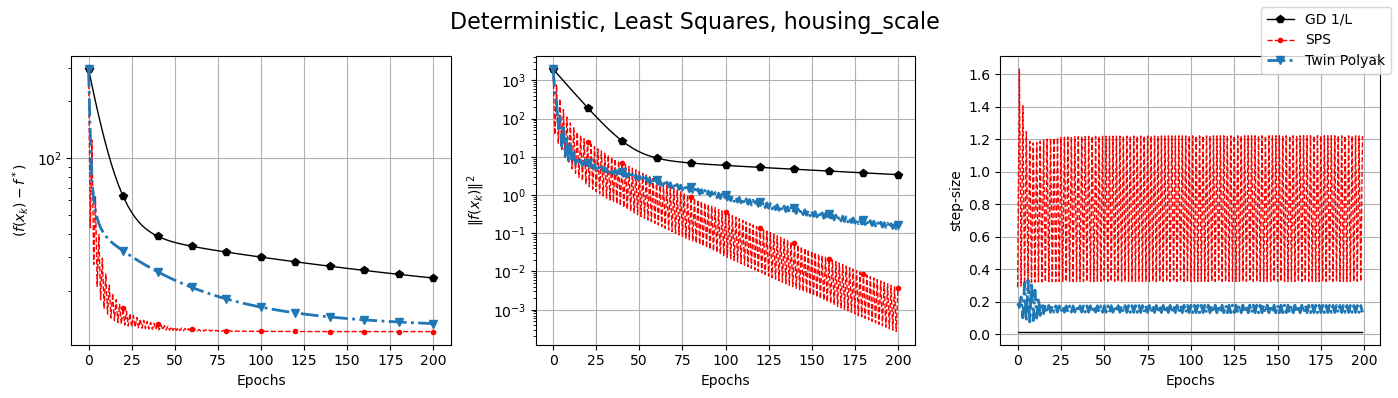

In [141]:
n_epochs = 200
seed = 0

histories = []
labels = []

hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
hist_sps = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SPS,
                seed=seed,
                f_star=fOpt,
                )
histories.append(hist_sps)
labels.append("SPS")


hist_twin = twin_model(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=["p", ".", "v", "v", "p"],
        f_star=fOpt, 
        suptitle=f"{setting}, Least Squares, {dataset_name}",
        threshold=0.0)